Manuel Montoya | manuel.montoya@pucp.edu.pe

# NSF Research Awards Abstracts

This dataset comprises several paper abstracts, one per file, that were furnished by the NSF (National Science Foundation).
Your task is developing an unsupervised model which classifies abstracts into a topic (discover them!). Indeed, your goal is to group abstracts based on their semantic similarity.

## 0. imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#libraries
######################################################################

import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm, tqdm_notebook
from pathlib import Path

import random
import warnings
import pickle


#configuration options
######################################################################

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_colwidth', 1000)
sns.set()

## 1. loading and parsing

As a first step, we are going to read and check the structure of the abstracts. We have downloaded the abstracts to the folder `sample`

How many files do we have and what format do they have?

In [2]:
folder_path = 'sample'

In [3]:
files = os.listdir(folder_path)
files[:10]

['2035358.xml',
 '2015088.xml',
 '2027984.xml',
 '2010696.xml',
 '2029017.xml',
 '2026324.xml',
 '2012081.xml',
 '2032345.xml',
 '2003198.xml',
 '2034734.xml']

In [4]:
len(files)

13146

In [5]:
set([file.split('.')[1] for file in files])

{'xml'}

We have 13145 files and all of them have `.xml` format

We load a *sample* file to check the structure

In [6]:
def load_file(filepath):
    '''
    load the content of filepath and return it as a string
    '''
    
    with open(filepath) as file:
        content = file.read()
        
    return content

In [7]:
print(load_file(f'sample/{files[0]}'))

<?xml version="1.0" encoding="UTF-8"?>
<rootTag>
<Award>
<AwardTitle>NSF Convergence Accelerator: Privacy and Pandemics: Responsible Use of Data During Times of Crisis</AwardTitle>
<AGENCY>NSF</AGENCY>
<AwardEffectiveDate>09/01/2020</AwardEffectiveDate>
<AwardExpirationDate>02/28/2021</AwardExpirationDate>
<AwardTotalIntnAmount>96096.00</AwardTotalIntnAmount>
<AwardAmount>96096</AwardAmount>
<AwardInstrument>
<Value>Standard Grant</Value>
</AwardInstrument>
<Organization>
<Code>01060500</Code>
<Directorate>
<Abbreviation>O/D</Abbreviation>
<LongName>Office Of The Director</LongName>
</Directorate>
<Division>
<Abbreviation>OIA</Abbreviation>
<LongName>Office of Integrative Activities</LongName>
</Division>
</Organization>
<ProgramOfficer>
<SignBlockName>Chaitanya Baru</SignBlockName>
<PO_EMAI/>
<PO_PHON/>
</ProgramOfficer>
<AbstractNarration>The NSF Convergence Accelerator supports team-based, multidisciplinary efforts that address challenges of national importance and show potential fo

With a quick Google search of the title *NSF Convergence Accelerator: Privacy and Pandemics: Responsible Use of Data During Times of Crisis* we could also find the source of the `.xml` file to check the tags and corresponding information https://www.nsf.gov/awardsearch/showAward?AWD_ID=2035358&HistoricalAwards=false

Taking into account that we're looking to develop an unsupervised model to identify topics
* We are going to use only the body of the abstract for the model
* We are exluding information like dates, sponsor or project outcomes report

Using the sample schema we create a couple of function to parse
* the body of the abstract section of the file between the tags `<AbstractNarration>` and `</AbstractNarration>`
* the title of the file between the tags `<AwardTitle>` and `</AwardTitle>`
* we are also saving the title and filename for reference

In [8]:
def parse_abstract_content(filepath):
    '''
    recieves an .xml filepath and parses the content between the tags of the abstract
    
    params: 
        filepath: string with file path
        
    returns:
        abstract: string with abstract
        
    '''
    
    with open(filepath) as file:
        content = file.read()
        
    try:
        
        # if there is an abstract section we extract it with the title
        title = content.split('<AwardTitle>')[1].split('</AwardTitle>')[0]
        abstract = content.split('<AbstractNarration>')[1].split('</AbstractNarration>')[0]
        
        return filepath, title, abstract
        
    except:
        
        return filepath, title, ''

We test the function with a couple of files

In [9]:
parse_abstract_content(f'sample/{files[0]}')

('sample/2035358.xml',
 'NSF Convergence Accelerator: Privacy and Pandemics: Responsible Use of Data During Times of Crisis',
 "The NSF Convergence Accelerator supports team-based, multidisciplinary efforts that address challenges of national importance and show potential for deliverables in the near future. The objective of this workshop is to explore topics for potential NSF Convergence Accelerator tracks for FY 2021.&lt;br/&gt;&lt;br/&gt;The Future of Privacy Forum (FPF) will convene a workshop on “The Responsible Use of Data During Times of Crisis”, for pandemics as well as other crisis situations. The workshop will bring together US government leaders, international data protection authorities, corporate leaders, technologists, academic researchers and public health experts to examine benefits, risks, and strategies for the collection and protection of data in support of public health initiatives during crises, including for COVID-19. &lt;br/&gt;&lt;br/&gt;Ensuring that US and glo

In [10]:
parse_abstract_content(f'sample/{files[-1]}')

('sample/2023523.xml',
 'Collaborative research: Patterns, causes, and consequences of synchrony in giant kelp populations',
 "Populations of organisms located in different, often far-apart places can change over time in similar ways. This natural phenomenon, known as synchrony, is important to many issues affecting societal well-being, such as those in medicine, public health, conservation, and natural resource management. For instance, synchrony is critical to the persistence, stability, and resilience of plant and animal populations, and can have cascading effects on biodiversity, ecosystem function, and associated benefits to society. However, many aspects of synchrony are poorly resolved. For example, understanding the influence of multiple potential drivers of synchrony—such as climatic events and predators—has been a longstanding challenge in ecology. Moreover, the causes of synchrony may change over space, time, and timescale (e.g., annual vs. decadal synchrony), but this poten

We load the complete list of abstracts and check if we got some errors while parsing

In [11]:
complete_abstracts = [parse_abstract_content(f'sample/{file}') for file in files]

We create a pandas dataframe with the parsed information

In [12]:
df_abstracts = pd.DataFrame(complete_abstracts, columns = ['file', 'title', 'abstract'])
df_abstracts.head()

,file,title,abstract
0,sample/2035358.xml,NSF Convergence Accelerator: Privacy and Pandemics: Responsible Use of Data During Times of Crisis,"The NSF Convergence Accelerator supports team-based, multidisciplinary efforts that address challenges of national importance and show potential for deliverables in the near future. The objective of this workshop is to explore topics for potential NSF Convergence Accelerator tracks for FY 2021.&lt;br/&gt;&lt;br/&gt;The Future of Privacy Forum (FPF) will convene a workshop on “The Responsible Use of Data During Times of Crisis”, for pandemics as well as other crisis situations. The workshop will bring together US government leaders, international data protection authorities, corporate leaders, technologists, academic researchers and public health experts to examine benefits, risks, and strategies for the collection and protection of data in support of public health initiatives during crises, including for COVID-19. &lt;br/&gt;&lt;br/&gt;Ensuring that US and global stakeholders leading emergency efforts have the data-based knowledge, tools and governance structures to navigate pandem..."
1,sample/2015088.xml,SBIR Phase I: Development of a low-cost Silicon Carbide Power Switch Technology,"The broader impact/commercial potential of this Small Business Innovation Research (SBIR) Phase I project is to accelerate the adoption of silicon carbide power semiconductors for energy efficient power electronics. The technology developed in this Phase I proposal will build an intelligent, low-cost, high-performance, silicon carbide power switch. The proposed technology can potentially increase energy efficiency by up to 10% and reduce power electronic energy dissipation by 5X for a wide range of applications, including industrial power supplies, motor drives, solar inverters, battery chargers, adapters for consumer electronics and in electric vehicles. In addition, the proposed technology is also an enabler for efficient power delivery in future applications such as electric aircraft, space flight and quantum computing.&lt;br/&gt;&lt;br/&gt;This Small Business Innovation Research (SBIR) Phase I project will demonstrate a novel four-terminal silicon carbide field-effect transist..."
2,sample/2027984.xml,RAPID: Collaborative: Transfer Learning Techniques for Better Response to COVID-19 in the US,"This project will use available data sets for COVID-19 in other countries, and in NYC, Virginia, and Maryland to build compartmental and metapopulation models to quantify the events that transpired there, and what interventions at various stages may have achieved. This will permit gaining control of future situations earlier. The epidemic models developed during this project will lead to innovations in computational epidemiology and enable approaches that mitigate the negative effects of COVID-19 on public health, society, and the economy.&lt;br/&gt;&lt;br/&gt;Based on publicly available data sets for COVID-19 in other countries, and in NYC, Virginia, and Maryland, the researchers propose to build compartmental and metapopulation models to quantify the events that transpired there, understand the impacts of interventions at various stages, and develop optimal strategies for containing the pandemic. The basic model will subdivide the population into classes according to age, gender..."
3,sample/2010696.xml,EAGER: MAKER: Student Learning Trajectories from Making Activities,"Arizona State University seeks to understand how open-ended, hands-on Making work and activities can reflect student learning gains in formal engineering education, particularly in an undergraduate, product-based course. The aim is to expand understanding of what Making and learning through Making in the context of engineering design education might be. The results generated during this study will describe the learning trajectories of engineers as they learn Making. These results will illustrate educational pathways within the engineering educat

We check if there were some files with a missing abstract

In [13]:
missing = df_abstracts[df_abstracts['abstract'] == '']
missing.shape

(70, 3)

In [14]:
missing.shape[0] / df_abstracts.shape[0]

0.005324813631522897

About 0.5% of the files don't have an abstract section or have it with a different structure. We check for some of the records to validate.

In [15]:
missing.sample(5)

,file,title,abstract
11230,sample/2053405.xml,Collaborative Research: Exploring System-Wide Events on Complex Fault Networks using Fully-Dynamic 3D Earthquake Cycle Simulations,
5010,sample/2001271.xml,Federal Investigations Reimbursable Billing,
10020,sample/2006228.xml,Employee (Detailee): Dr. Timothy Wojan,
9463,sample/2013252.xml,"Intergovernmental Personnel Act (IPA) assignment. This agreement will cover the period January 1, 2020 through December 31, 2021.",
11715,sample/2028064.xml,Detail between Naval Postgraduate School and National Science Foundation for Dr. Robert Beverly.(Year 1),


We check how is the structure of these files to see if there is something we can do to get the abstract

In [16]:
load_file('sample/2054031.xml')

'<?xml version="1.0" encoding="UTF-8"?>\n<rootTag>\n<Award>\n<AwardTitle>DOI IBC</AwardTitle>\n<AwardEffectiveDate>09/16/2020</AwardEffectiveDate>\n<AwardExpirationDate>09/16/2021</AwardExpirationDate>\n<AwardTotalIntnAmount>786280.00</AwardTotalIntnAmount>\n<AwardAmount>786280</AwardAmount>\n<AwardInstrument>\n<Value>Contract Interagency Agreement</Value>\n</AwardInstrument>\n<Organization>\n<Code>02040003</Code>\n<Directorate>\n<Abbreviation>IRM</Abbreviation>\n<LongName>Office Of Information &amp; Resource Mgmt</LongName>\n</Directorate>\n<Division>\n<Abbreviation>HRM</Abbreviation>\n<LongName>Division Of Human Resource Management</LongName>\n</Division>\n</Organization>\n<ProgramOfficer>\n<SignBlockName>Vincent Culliver</SignBlockName>\n</ProgramOfficer>\n<AbstractNarration/>\n<MinAmdLetterDate>09/21/2020</MinAmdLetterDate>\n<MaxAmdLetterDate>09/21/2020</MaxAmdLetterDate>\n<ARRAAmount/>\n<AwardID>2054031</AwardID>\n<Investigator>\n<FirstName>Bill</FirstName>\n<LastName>Stebbins</La

In [17]:
load_file('sample/2012963.xml')

'<?xml version="1.0" encoding="UTF-8"?>\n<rootTag>\n<Award>\n<AwardTitle>IAA for special issuance passports</AwardTitle>\n<AwardEffectiveDate>12/15/2019</AwardEffectiveDate>\n<AwardExpirationDate>12/31/2020</AwardExpirationDate>\n<AwardTotalIntnAmount>13800.00</AwardTotalIntnAmount>\n<AwardAmount>0</AwardAmount>\n<AwardInstrument>\n<Value>Contract Interagency Agreement</Value>\n</AwardInstrument>\n<Organization>\n<Code>02060000</Code>\n<Directorate>\n<Abbreviation>IRM</Abbreviation>\n<LongName>Office Of Information &amp; Resource Mgmt</LongName>\n</Directorate>\n<Division>\n<Abbreviation>DAS</Abbreviation>\n<LongName>Division Of Administrative Services</LongName>\n</Division>\n</Organization>\n<ProgramOfficer>\n<SignBlockName>Antonio Bermudez</SignBlockName>\n</ProgramOfficer>\n<AbstractNarration/>\n<MinAmdLetterDate>12/03/2019</MinAmdLetterDate>\n<MaxAmdLetterDate>06/18/2020</MaxAmdLetterDate>\n<ARRAAmount/>\n<AwardID>2012963</AwardID>\n<Investigator>\n<FirstName>Jerene</FirstName>\n<

Apparently there are some files that effectively don't have an abstract so we remove them from the analysis

In [18]:
df_abstracts = df_abstracts[df_abstracts['abstract'] != '']
df_abstracts.shape

(13076, 3)

We still have more than 13k files

Just to have an extra validation we are going to plot the distribution of the length of the abstracts just to be sure we didn't get something wrong

In [19]:
df_abstracts['length'] = df_abstracts['abstract'].str.len()

In [20]:
df_abstracts.head(1)

,file,title,abstract,length
0,sample/2035358.xml,NSF Convergence Accelerator: Privacy and Pandemics: Responsible Use of Data During Times of Crisis,"The NSF Convergence Accelerator supports team-based, multidisciplinary efforts that address challenges of national importance and show potential for deliverables in the near future. The objective of this workshop is to explore topics for potential NSF Convergence Accelerator tracks for FY 2021.&lt;br/&gt;&lt;br/&gt;The Future of Privacy Forum (FPF) will convene a workshop on “The Responsible Use of Data During Times of Crisis”, for pandemics as well as other crisis situations. The workshop will bring together US government leaders, international data protection authorities, corporate leaders, technologists, academic researchers and public health experts to examine benefits, risks, and strategies for the collection and protection of data in support of public health initiatives during crises, including for COVID-19. &lt;br/&gt;&lt;br/&gt;Ensuring that US and global stakeholders leading emergency efforts have the data-based knowledge, tools and governance structures to navigate pandem...",2668


<AxesSubplot:xlabel='length', ylabel='Count'>

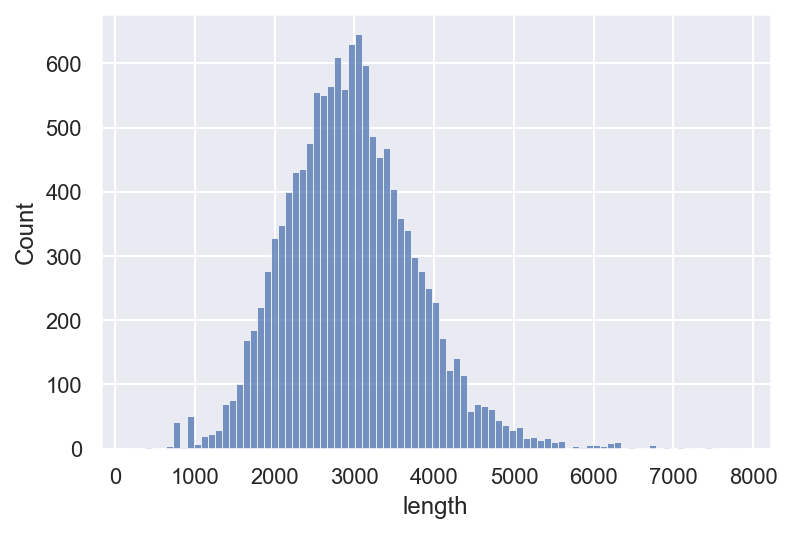

In [21]:
sns.histplot(data = df_abstracts, x = 'length')

In [22]:
df_abstracts.describe(percentiles = np.arange(0.05, 1, 0.05))

,length
count,13076.000000
mean,2957.449296
std,822.072379
min,201.000000
5%,1724.000000
10%,1965.000000
15%,2133.000000
20%,2268.000000
25%,2402.000000
30%,2520.000000


The length distribution seems ok with some outliers on both sides.

In [23]:
df_abstracts.query('length < 300')

,file,title,abstract,length
1163,sample/2026509.xml,eOPF,&lt;br/&gt;&lt;br/&gt;This award reflects NSF's statutory mission and has been deemed worthy of support through evaluation using the Foundation's intellectual merit and broader impacts review criteria.,201


In [24]:
load_file('sample/2026509.xml')

'<?xml version="1.0" encoding="UTF-8"?>\n<rootTag>\n<Award>\n<AwardTitle>eOPF</AwardTitle>\n<AwardEffectiveDate>09/01/2020</AwardEffectiveDate>\n<AwardExpirationDate>09/01/2021</AwardExpirationDate>\n<AwardTotalIntnAmount>40021.00</AwardTotalIntnAmount>\n<AwardAmount>40021</AwardAmount>\n<AwardInstrument>\n<Value>Contract Interagency Agreement</Value>\n</AwardInstrument>\n<Organization>\n<Code>02040003</Code>\n<Directorate>\n<Abbreviation>IRM</Abbreviation>\n<LongName>Office Of Information &amp; Resource Mgmt</LongName>\n</Directorate>\n<Division>\n<Abbreviation>HRM</Abbreviation>\n<LongName>Division Of Human Resource Management</LongName>\n</Division>\n</Organization>\n<ProgramOfficer>\n<SignBlockName>Vincent Culliver</SignBlockName>\n</ProgramOfficer>\n<AbstractNarration>&lt;br/&gt;&lt;br/&gt;This award reflects NSF\'s statutory mission and has been deemed worthy of support through evaluation using the Foundation\'s intellectual merit and broader impacts review criteria.</AbstractNar

In [25]:
df_abstracts.query('length > 7800')

,file,title,abstract,length
4323,sample/2046063.xml,"CAREER: Geometries of Topological Defects in 3D Nematics, from Equilibrium Structure to Active Dynamics","NONTECHNICAL SUMMARY&lt;br/&gt;This CAREER award supports theoretical and computational research and education to advance understanding of how complex, functional organization arises in living and lifelike systems from the interactions of many similar units. From the cytoskeleton within cells up to animal swarms and flocks, nature abounds with examples of collective organization and collective motion with critically important functions, such as cell division and foraging for food. Recently, insights from statistical and soft materials physics have helped to uncover general principles underlying such collective behaviors across many size scales and species. This physics of active matter, because of its wide applicability, is guiding the design of new, advanced materials that mimic functionalities of living systems, such as the capability to sense their environment, internally rearrange, move, divide, or self-heal. &lt;br/&gt;&lt;br/&gt;Active nematics constitute one prominent class ...",7837


In [26]:
df_abstracts.loc[4323, 'abstract']

"NONTECHNICAL SUMMARY&lt;br/&gt;This CAREER award supports theoretical and computational research and education to advance understanding of how complex, functional organization arises in living and lifelike systems from the interactions of many similar units. From the cytoskeleton within cells up to animal swarms and flocks, nature abounds with examples of collective organization and collective motion with critically important functions, such as cell division and foraging for food. Recently, insights from statistical and soft materials physics have helped to uncover general principles underlying such collective behaviors across many size scales and species. This physics of active matter, because of its wide applicability, is guiding the design of new, advanced materials that mimic functionalities of living systems, such as the capability to sense their environment, internally rearrange, move, divide, or self-heal. &lt;br/&gt;&lt;br/&gt;Active nematics constitute one prominent class of 

## 2. data preparation

In [27]:
# some extra imports for string preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist

To prepare the raw abstracts for the model, we are going to make some preprocessing:
* we tokenize the abstract
* we convert the tokens to lowercase
* we exclude tokens that are not words (not a number or character)
* we exclude tokens that are stopwords
* we lemmatize the tokens

In [28]:
english_stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [29]:
def text_preparation(text):
    
    #tokenize and lowercase
    tokens = [token.lower() for token in word_tokenize(text)]
    
    #lemmatize only if word and not stopword
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in english_stopwords]
    
    return ' '.join(tokens)

we vectorize the transformation to help with speed

In [30]:
np_text_preparation = np.vectorize(text_preparation)

*this takes some time*

In [31]:
df_abstracts['prep_abstract'] = np_text_preparation(df_abstracts['abstract'])

In [32]:
df_abstracts.sample(2)

,file,title,abstract,length,prep_abstract
5178,sample/2028542.xml,RAPID: Silver and Copper-based Nanowire Structures for Antiviral Applications,"Non-Technical Abstract: &lt;br/&gt;The current COVID-19 pandemic has identified key problems in the US strategic preparedness for a national biological disaster. One of those is a shortage of N95 respirators, which provide critical protection to medical personnel as they treat infected patients. This issue is a direct consequence of the one-time-use nature of these N95 respirators; polymer fiber filters, including N95 and HEPA filters, capture and accumulate live pathogens, and so become biohazardous. In the proposed work, metallic nanowire bird’s nests and electrospun fibers are presented as approaches to resolve these problems, resulting in an improved respirator. The porous metallic nanowire bird’s nests allow air to pass through, similar to a polymer fiber filter, but the metallic surfaces possess antibacterial and antiviral qualities. As a consequence, pathogens captured in the bird’s nest are inactivated, improving the protection to medical workers and prolonging the usefulne...",3843,abstract lt gt current pandemic identified key problem u strategic preparedness national biological disaster one shortage respirator provide critical protection medical personnel treat infected patient issue direct consequence nature respirator polymer fiber filter including hepa filter capture accumulate live pathogen become biohazardous proposed work metallic nanowire bird nest electrospun fiber presented approach resolve problem resulting improved respirator porous metallic nanowire bird nest allow air pas similar polymer fiber filter metallic surface posse antibacterial antiviral quality consequence pathogen captured bird nest inactivated improving protection medical worker prolonging usefulness respirator metallic nanowires also integrated free surface electrospinning device resulting polymer fiber hairy nanowires electrospun respirator melted new respirator recycling step allows respirator continuously removing need constantly effort together may resolve shortage respirator c...
3080,sample/2011759.xml,The Multi-Mission Maximum Likelihood Framework (3ML): a Tool to Explore the High-Energy Universe in the Era of Multi Messenger Astrophysics,"Astrophysical sources are now observed by many instruments at wavelengths from radio to high-energy gamma-rays, and using different messengers, including light, light polarization, neutrinos, cosmic rays, and gravitational waves. Extracting insight from these data is currently very difficult because each instrument has its own data format, software, and analysis procedure, each requiring specialized knowledge and training. The Multi-Mission Maximum Likelihood framework (3ML) solves this issue, allowing easy modeling using all available data, independent of origin. Each instrument provides an interface from their data to 3ML, while 3ML optimizes model parameters to match all of the data as well as possible. This award supports the continued development of 3ML, focusing in particular on enabling new science for the High-Altitude Water Cerenkov telescope (HAWC) through the HAWC Accelerated Likelihood (HAL), a new 3ML component. The project includes tutorials to promote the use of...",1927,astrophysical source observed many instrument wavelength radio using different messenger including light light polarization neutrino cosmic ray gravitational wave extracting insight data currently difficult instrument data format software analysis procedure requiring specialized knowledge training maximum likelihood framework solves issue allowing easy modeling using available data independent origin instrument provides interface data optimizes model parameter match data well possible award support continued development focusing particular enabling new science water cerenkov telescope hawc hawc accelerated likelihood hal new component project includes tutorial promote use st

We check some of the most common words

In [33]:
f = FreqDist(word_tokenize(' '.join(df_abstracts['prep_abstract'])))

In [34]:
f.most_common(100)

[('gt', 60025),
 ('lt', 59943),
 ('project', 43645),
 ('research', 35895),
 ('student', 23504),
 ('support', 21937),
 ('using', 21077),
 ('impact', 20778),
 ('data', 18402),
 ('award', 16053),
 ('broader', 15787),
 ('nsf', 15277),
 ('new', 15230),
 ('system', 15217),
 ('foundation', 14193),
 ('evaluation', 13859),
 ('model', 13677),
 ('intellectual', 13297),
 ('mission', 13227),
 ('merit', 13133),
 ('review', 13086),
 ('criterion', 12994),
 ('reflects', 12884),
 ('deemed', 12845),
 ('statutory', 12830),
 ('worthy', 12829),
 ('science', 12709),
 ('program', 11367),
 ('study', 11212),
 ('also', 10253),
 ('development', 9989),
 ('learning', 9836),
 ('community', 9662),
 ('understanding', 9302),
 ('material', 9198),
 ('stem', 8927),
 ('develop', 8874),
 ('provide', 8576),
 ('use', 8316),
 ('technology', 8220),
 ('process', 8092),
 ('work', 7523),
 ('change', 7456),
 ('method', 7452),
 ('education', 7364),
 ('undergraduate', 7359),
 ('approach', 7264),
 ('design', 6978),
 ('field', 6973),
 

In [35]:
df_abstracts[df_abstracts['prep_abstract'].str.contains('gt')].head()

,file,title,abstract,length,prep_abstract
0,sample/2035358.xml,NSF Convergence Accelerator: Privacy and Pandemics: Responsible Use of Data During Times of Crisis,"The NSF Convergence Accelerator supports team-based, multidisciplinary efforts that address challenges of national importance and show potential for deliverables in the near future. The objective of this workshop is to explore topics for potential NSF Convergence Accelerator tracks for FY 2021.&lt;br/&gt;&lt;br/&gt;The Future of Privacy Forum (FPF) will convene a workshop on “The Responsible Use of Data During Times of Crisis”, for pandemics as well as other crisis situations. The workshop will bring together US government leaders, international data protection authorities, corporate leaders, technologists, academic researchers and public health experts to examine benefits, risks, and strategies for the collection and protection of data in support of public health initiatives during crises, including for COVID-19. &lt;br/&gt;&lt;br/&gt;Ensuring that US and global stakeholders leading emergency efforts have the data-based knowledge, tools and governance structures to navigate pandem...",2668,nsf convergence accelerator support multidisciplinary effort address challenge national importance show potential deliverable near future objective workshop explore topic potential nsf convergence accelerator track fy lt gt lt gt future privacy forum fpf convene workshop responsible use data time crisis pandemic well crisis situation workshop bring together u government leader international data protection authority corporate leader technologist academic researcher public health expert examine benefit risk strategy collection protection data support public health initiative crisis including lt gt lt gt ensuring u global stakeholder leading emergency effort knowledge tool governance structure navigate pandemic challenge one defining public policy issue time workshop explore proposed convergence accelerator track accelerate collaboration among government industry academic researcher make health data effective usable achieve positive lasting impact future preparedness pandemic crisis ...
1,sample/2015088.xml,SBIR Phase I: Development of a low-cost Silicon Carbide Power Switch Technology,"The broader impact/commercial potential of this Small Business Innovation Research (SBIR) Phase I project is to accelerate the adoption of silicon carbide power semiconductors for energy efficient power electronics. The technology developed in this Phase I proposal will build an intelligent, low-cost, high-performance, silicon carbide power switch. The proposed technology can potentially increase energy efficiency by up to 10% and reduce power electronic energy dissipation by 5X for a wide range of applications, including industrial power supplies, motor drives, solar inverters, battery chargers, adapters for consumer electronics and in electric vehicles. In addition, the proposed technology is also an enabler for efficient power delivery in future applications such as electric aircraft, space flight and quantum computing.&lt;br/&gt;&lt;br/&gt;This Small Business Innovation Research (SBIR) Phase I project will demonstrate a novel four-terminal silicon carbide field-effect transist...",1954,broader potential small business innovation research sbir phase project accelerate adoption silicon carbide power semiconductor energy efficient power electronics technology developed phase proposal build intelligent silicon carbide power switch proposed technology potentially increase energy efficiency reduce power electronic energy dissipation wide range application including industrial power supply motor drive solar inverter battery charger adapter consumer electronics electric vehicle addition proposed technology also enabler efficient power delivery future application electric aircraft space flight quantum lt gt lt gt small business innovation research sbir phase project demonstrate novel silicon carbide trans

`gt` and `lt` tokens seem to appear a lot because of some pattern like this `&lt;br/&gt;&lt;br/&gt`. We are going to remove it from the processed abstracts and check again the most popular words

In [36]:
df_abstracts['prep_abstract'] = df_abstracts['prep_abstract'].str.replace('gt', '')
df_abstracts['prep_abstract'] = df_abstracts['prep_abstract'].str.replace('lt', '')

In [37]:
f = FreqDist(word_tokenize(' '.join(df_abstracts['prep_abstract'])))

In [38]:
f.most_common(10)

[('project', 43645),
 ('research', 35895),
 ('student', 23504),
 ('support', 21937),
 ('using', 21077),
 ('impact', 20778),
 ('data', 18402),
 ('award', 16053),
 ('broader', 15787),
 ('nsf', 15277)]

## 3. topic modeling

* Since each abstract may be related to one of many topics we are going to use a soft clustering algorithm. 
* With this algorithm we generate a number of topics (defined by us) and a probability that each abstract belongs to each one of them. 
* We prefer this  over a hard clustering like KMeans because in KMeans each abstract belongs to only one topic.
* We are going to use the Latent Dirichlet Allocation algorithm. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [39]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

We generate the bag of words as input to the algorithm using only the tokens that have a document frequency of 5 or more

In [40]:
bag = CountVectorizer(min_df = 5)
matrix = bag.fit_transform(df_abstracts['prep_abstract'])
matrix.shape

(13076, 14672)

Our final vocabulary consists of 14672 words

In [41]:
feature_names = bag.get_feature_names()
len(feature_names)

14672

We can see the bag of words for each abstract (this is just for illustrative purpouses and should not be done if the matrix is too big)

In [42]:
pd.DataFrame(data = matrix.toarray(), index = df_abstracts['file'], columns = feature_names).head(1)

,aa,aaa,aabw,aaniiih,ab,abandon,abandoned,abandonment,abbreviated,abdomen,abdominal,abelian,aberrant,aberration,abet,ability,abiotic,ablation,able,abnormal,abnormality,aboard,abound,abrasion,abroad,abrupt,abruptly,absence,absent,absolute,absolutely,absorb,absorbed,absorber,absorbing,absorbs,absorption,abstract,abstracted,abstracting,abstraction,abundance,abundant,abundantly,abuse,abuts,abyssal,ac,academe,academia,academic,academically,academy,acc,accelerate,accelerated,accelerates,accelerating,acceleration,accelerator,accelerometer,accelnet,accent,accentuated,accept,acceptability,acceptable,acceptance,accepted,accepting,acceptor,accepts,access,accesscomputing,accessed,accessibility,accessible,accessing,accessory,accident,accidental,acclimate,acclimating,acclimation,acclimatization,accommodate,accommodated,accommodates,accommodating,accommodation,accompanied,accompanies,accompany,accompanying,accomplish,accomplished,accomplishes,accomplishing,accomplishment,accordance,according,accordingly,account,accountability,accountable,accounted,accounting,accreditation,accredited,accrete,accreted,accreting,accretion,accretionary,accrue,accumulate,accumulated,accumulates,accumulating,accumulation,accuracy,accurate,accurately,ace,achievable,achieve,achieved,achievement,achieves,achieving,acid,acidic,acidification,acidity,acknowledge,acknowledged,acknowledgement,acknowledging,acm,acoustic,acoustically,acquire,acquired,acquiring,acquisition,acre,across,acrotelm,act,acted,actin,acting,action,actionable,activate,activated,activates,activating,activation,activator,active,actively,activist,activity,actor,actual,actually,actuarial,actuate,actuated,actuating,actuation,actuator,acute,acutely,ad,ada,adam,adapt,adaptability,adaptable,adaptation,adapted,adapting,adaption,adaptive,adaptively,adaptivity,adapts,adcp,add,added,addiction,adding,addition,additional,additionally,additive,additively,address,addressable,addressed,addressing,adept,adequate,adequately,adhd,adhere,adherence,adhering,adhesion,adhesive,adiabatic,adjacency,adjacent,adjoining,adjoint,adjust,adjustable,adjusted,adjusting,adjustment,adjusts,adjuvant,administer,administered,administering,administration,administrative,administrator,admissible,admission,admit,admitted,admitting,adolescence,adolescent,adopt,adopted,adopter,adopting,adoption,adopts,adsorb,adsorbate,adsorbed,adsorbent,adsorption,adsorptive,adu,aduhood,advance,advanced,advancement,advancing,advantage,advantaged,advantageous,advected,advection,advent,adversarial,adversary,adverse,adversely,adversity,advertise,advertised,advertisement,advertising,advice,advise,adviser,advising,advisor,advisory,advocacy,advocate,advocated,advocating,adélie,aer,aerated,aeration,aered,aerial,aering,aernate,aernately,aernating,aernation,aernative,aernatively,aerobic,aerodynamic,aerodynamics,aerogel,aerogels,aeronautical,aeronautics,aeronomy,aerosol,aerosolized,aerospace,aers,aeruginosa,aesthetic,af,affair,affect,affected,affecting,affective,affiliate,affiliated,affiliation,affine,affinity,afflicted,affliction,affluent,afford,affordability,affordable,affordances,afforded,affording,affords,afm,aforementioned,africa,african,afterglow,aftermath,afternoon,afterschool,aftershock,afterwards,ag,age,aged,agency,agenda,agent,agep,aggravated,aggregate,aggregated,aggregating,aggregation,aggregator,aggression,aggressive,aggressively,agile,agility,aging,agn,agnostic,ago,agonist,agonistic,agrarian,agree,agreed,agreement,agricuural,agricuurally,agricuure,agrochemical,agrochemicals,agroecosystem,agroecosystems,agu,ahead,ahough,ai,aid,aided,aiding,ailment,aim,aimed,aiming,air,airborne,aircraft,airflow,airfoil,airglow,airline,airplane,airport,airspace,airway,aisl,aitude,ak,aka,akin,akron,al,alabama,alamo,alar,alarm,alarming,alarmingly,alaska,alaskan,albany,albedo,albeit,albuquerque,alcohol,aldehyde,ale,alert,alerting,aleutian,alexander,alexandria,alfa,alfalfa,algaas,algae,algal,algebra,algebraic,algebraically,algorithm,algorithmic,algorithmically,aliasing,alice,align,

About the LDA algorithm

* We specify a number of topics (`n_components`) By default this number is 10, we are keeping it that way.
* The learning method is set to online so that in each iteration the components are updated using only a `batch_size` number of records and not all training data. This helps with the training speed.

In [50]:
lda = LatentDirichletAllocation(n_components=10, max_iter=10, 
                                learning_method='online', batch_size=256, verbose=True, random_state = 12345)

lda.fit(matrix)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=256, learning_method='online',
                          random_state=12345, verbose=True)

we save the model for reproducibility

In [51]:
with open('lda_model.pkl', 'wb') as file:
    pickle.dump(lda, file)

In [52]:
with open('lda_model.pkl', 'rb') as file:
    lda = pickle.load(file)

The output is a matrix that has as rows each topic and as columns each feature. At position `[topic, feature]` we get a number that represents the number of times that word `feature` was assigned to the `topic`

In [53]:
lda.components_.shape

(10, 14672)

In [54]:
topics = pd.DataFrame(lda.components_, columns = feature_names)
topics

aa       aaa       aabw   aaniiih         ab   abandon  abandoned  \
0   0.100142  0.100006   0.100000  0.100003   0.100059  0.100040   0.100024   
1   0.244795  0.100009   0.100010  0.100018   0.100001  0.100240   0.100123   
2   0.100109  0.100002   0.100001  0.100003   0.100059  0.100004   0.100078   
3   0.100199  4.823235   0.100000  4.859284   0.100002  0.100002   1.140554   
4   0.100011  6.323256   0.100009  0.100019   0.100032  0.100001   0.100001   
5   0.100004  0.100001   0.100000  0.100000   0.100103  0.100015   0.100007   
6  25.387224  0.100001   0.100000  0.100007   1.924193  4.911105   0.100025   
7   1.360944  0.100019   0.100000  0.100012  36.718418  0.100014   0.100005   
8   0.100060  0.100005  57.805797  0.100000   0.100123  0.100030  14.789895   
9   0.100070  0.105979   0.100000  0.100000  19.141432  0.100021   0.100002   

   abandonment  abbreviated    abdomen  abdominal    abelian   aberrant  \
0     0.100070     0.100072  11.204089  15.940993   0.100016   0.100006   
1    12.587474     5.712519   0.100049   0.100002   0.100001   0.100001   
2     0.100009     0.100137   0.100010   0.100004   0.100007   0.100003   
3     0.100002     0.100034   0.100000   0.100001   0.100001   0.100002   
4     0.100006     0.100678   0.100177   0.100028   0.100001  18.208099   
5     0.100014     1.824706   0.100022   0.100008   0.100082   0.100000   
6     8.040254     0.100069   0.100024   0.100002   0.100171   0.100003   
7     0.100004     0.100127   0.100000   0.100002   0.100248   0.100014   
8     0.100106     0.100020   0.100023   0.100005  31.701808   0.100001   
9     0.100002     0.100120   0.100002   0.100009   0.100021   0.100003   

   aberration       abet     ability    abiotic   ablation        able  \
0    0.100003   0.100002  234.439078   0.100014  19.629820   95.195603   
1    0.100011   0.100001  200.078881  71.517050   0.100021   58.390105   
2    0.100011   0.100008  361.045623   0.100001   0.100002  174.687672   
3    0.100000  11.708163  332.244024   0.100003   0.100003   87.383153   
4    1.938682   0.100001  528.430761  50.201234   0.100033   54.911987   
5    0.100038   0.100025    3.827510   0.100001   0.100013  104.906211   
6    0.100033   0.100001  317.858285   0.100002   0.100017  160.532180   
7    8.995892   0.100002   29.097837   0.100042   3.085217   71.330533   
8    0.100608   0.100000  151.451192   0.100919   9.203577   66.895843   
9    0.100016   0.100001  305.680847   0.100023   2.764345   20.540910   

    abnormal  abnormality     aboard    abound   abrasion     abroad  \
0  13.960647     8.329771   0.100051  0.100009   0.100039   6.420163   
1   0.100003     0.100015   0.507858  0.100159   0.100005  50.860186   
2   0.100018     0.100016   0.100019  0.100133   0.103460   0.100061   
3   0.100007     0.100004   3.618380  0.100077   0.100001   0.100050   
4  23.975376     6.350464   0.100000  0.100002   0.100003   0.100016   
5   0.100094     0.100033   0.100014  0.100149   0.100006   0.102115   
6  11.070199     0.100008   0.100000  8.338643   0.100003   0.100016   
7   0.100012     0.100003   0.100009  0.100040   0.100003  12.613797   
8   0.100003     0.100001  14.963120  0.100565  15.839679   0.100085   
9  10.504032     0.100015   0.100002  0.100010   0.100053   0.100595   

      abrupt  abruptly    absence     absent   absolute  absolutely  \
0   0.100015  0.100141  50.138721   0.100026   0.100176    0.100007   
1  36.072617  9.536513   0.100732   2.898582   0.100029    0.100009   
2   0.100062  0.100011   0.100056  14.813924   0.100019    0.100011   
3   0.100035  0.100247   0.102451   0.100060   0.100059    0.100002   
4   0.100002  0.100016  31.432980  12.514024   0.100030    0.100002   
5   0.100140  0.100012   0.100025   0.100040   0.100112    0.100024   
6   0.100032  0.100190  42.430155   3.569580   8.608799    9.086330   
7   0.100049  0.100051  15.528130   0.393574  71.792400    0.100014   
8  35.890116  6.377196  25.077873  10.173087  14.274953    0.100075

### 3.1 interpretation

We can get the most relevant words for each topic using the components matrix

In [55]:
#for each topic
for id_topic, topic in enumerate(lda.components_):
    
    #get topic row
    total_words = lda.components_[id_topic]
    
    #get index of highest 10 feature values
    index_best_words = total_words.argsort()[:-10:-1]

    #get names of features 
    best_words = [feature_names[i] for i in index_best_words]
    
    # show words
    print(f'Topic {id_topic}')
    print(best_words)
    print('')

Topic 0
['project', 'heah', 'impact', 'using', 'broader', 'social', 'pandemic', 'research', 'disease']

Topic 1
['research', 'project', 'change', 'community', 'data', 'impact', 'environmental', 'ecosystem', 'using']

Topic 2
['project', 'data', 'research', 'technology', 'system', 'new', 'support', 'using', 'impact']

Topic 3
['student', 'project', 'research', 'stem', 'program', 'support', 'science', 'education', 'learning']

Topic 4
['cell', 'project', 'protein', 'research', 'using', 'biological', 'plant', 'biology', 'gene']

Topic 5
['system', 'project', 'computing', 'application', 'network', 'device', 'research', 'power', 'impact']

Topic 6
['project', 'model', 'data', 'learning', 'problem', 'method', 'theory', 'research', 'using']

Topic 7
['research', 'quantum', 'award', 'physic', 'support', 'university', 'student', 'new', 'nsf']

Topic 8
['project', 'model', 'ocean', 'using', 'impact', 'earth', 'process', 'support', 'water']

Topic 9
['material', 'research', 'project', 'property',

We can see that most of the topics are about projects and research (which makes sense because of the dataset). However, without being an expert in the matter, we can infer some names for the topics

Botany
* 0: Diseases and Pandemic
* 1: Environment and Community
* 2: Support and Impact of technology
* 3: STEM education and learning
* 4: Biology and Botany
* 5: Computers
* 6: Models and data for learning
* 7: Quantum physics
* 8: Environmental impact
* 9: Chemistry, energy and materials

### 3.2 assigning topics to each abstract

In [56]:
pd.set_option('display.max_colwidth', 100)

we use a dict to rename the columns

In [66]:
topics = {0: 'Diseases and Pandemic',
            1: 'Environment and Community',
            2: 'Support and Impact of technology',
            3: 'STEM education and learning',
            4: 'Biology and Botany',
            5: 'Computers',
            6: 'Models and data for learning',
            7: 'Quantum physics',
            8: 'Environmental impact',
            9: 'Chemistry, energy and materials'}

In [67]:
pred_topics = lda.transform(matrix)
pred_topics = pd.DataFrame(data = pred_topics)
pred_topics = pred_topics.rename(columns = topics)
pred_topics.head()

,Diseases and Pandemic,Environment and Community,Support and Impact of technology,STEM education and learning,Biology and Botany,Computers,Models and data for learning,Quantum physics,Environmental impact,"Chemistry, energy and materials"
0,0.235480,0.000467,0.506201,0.239804,0.000467,0.000467,0.000467,0.015710,0.000467,0.000467
1,0.069849,0.000617,0.048527,0.000617,0.000617,0.646978,0.000617,0.000617,0.000617,0.230942
2,0.810675,0.000725,0.000725,0.000725,0.000725,0.000725,0.183526,0.000725,0.000725,0.000725
3,0.000758,0.000758,0.000758,0.872059,0.000758,0.000758,0.101191,0.000758,0.000758,0.021446
4,0.220948,0.061306,0.000572,0.000572,0.000572,0.000572,0.000572,0.000572,0.424862,0.289454


In [68]:
pred_topics.shape

(13076, 10)

In [69]:
df_abstracts.head()

,file,title,abstract,length,prep_abstract
0,sample/2035358.xml,NSF Convergence Accelerator: Privacy and Pandemics: Responsible Use of Data During Times of Crisis,"The NSF Convergence Accelerator supports team-based, multidisciplinary efforts that address chal...",2668,nsf convergence accelerator support muidisciplinary effort address challenge national importance...
1,sample/2015088.xml,SBIR Phase I: Development of a low-cost Silicon Carbide Power Switch Technology,The broader impact/commercial potential of this Small Business Innovation Research (SBIR) Phase ...,1954,broader potential small business innovation research sbir phase project accelerate adoption sili...
2,sample/2027984.xml,RAPID: Collaborative: Transfer Learning Techniques for Better Response to COVID-19 in the US,"This project will use available data sets for COVID-19 in other countries, and in NYC, Virginia,...",1721,project use available data set country nyc virginia maryland build compartmental metapopulation ...
3,sample/2010696.xml,EAGER: MAKER: Student Learning Trajectories from Making Activities,"Arizona State University seeks to understand how open-ended, hands-on Making work and activities...",1605,arizona state university seek understand making work activity reflect student learning gain form...
4,sample/2029017.xml,Collaborative Research: Photochemical Silicon Aerosols: Establishing Atmospheric Sources and Sig...,This research is focused on improving the understanding of the chemical and physical transformat...,2177,research focused improving understanding chemical physical transformation volatile methyl siloxa...


In [70]:
df_abstracts.shape

(13076, 5)

In [71]:
model_output = pd.concat([df_abstracts.reset_index(drop = True), pred_topics], axis = 1)
model_output.head()

,file,title,abstract,length,prep_abstract,Diseases and Pandemic,Environment and Community,Support and Impact of technology,STEM education and learning,Biology and Botany,Computers,Models and data for learning,Quantum physics,Environmental impact,"Chemistry, energy and materials"
0,sample/2035358.xml,NSF Convergence Accelerator: Privacy and Pandemics: Responsible Use of Data During Times of Crisis,"The NSF Convergence Accelerator supports team-based, multidisciplinary efforts that address chal...",2668,nsf convergence accelerator support muidisciplinary effort address challenge national importance...,0.235480,0.000467,0.506201,0.239804,0.000467,0.000467,0.000467,0.015710,0.000467,0.000467
1,sample/2015088.xml,SBIR Phase I: Development of a low-cost Silicon Carbide Power Switch Technology,The broader impact/commercial potential of this Small Business Innovation Research (SBIR) Phase ...,1954,broader potential small business innovation research sbir phase project accelerate adoption sili...,0.069849,0.000617,0.048527,0.000617,0.000617,0.646978,0.000617,0.000617,0.000617,0.230942
2,sample/2027984.xml,RAPID: Collaborative: Transfer Learning Techniques for Better Response to COVID-19 in the US,"This project will use available data sets for COVID-19 in other countries, and in NYC, Virginia,...",1721,project use available data set country nyc virginia maryland build compartmental metapopulation ...,0.810675,0.000725,0.000725,0.000725,0.000725,0.000725,0.183526,0.000725,0.000725,0.000725
3,sample/2010696.xml,EAGER: MAKER: Student Learning Trajectories from Making Activities,"Arizona State University seeks to understand how open-ended, hands-on Making work and activities...",1605,arizona state university seek understand making work activity reflect student learning gain form...,0.000758,0.000758,0.000758,0.872059,0.000758,0.000758,0.101191,0.000758,0.000758,0.021446
4,sample/2029017.xml,Collaborative Research: Photochemical Silicon Aerosols: Establishing Atmospheric Sources and Sig...,This research is focused on improving the understanding of the chemical and physical transformat...,2177,research focused improving understanding chemical physical transformation volatile methyl siloxa...,0.220948,0.061306,0.000572,0.000572,0.000572,0.000572,0.000572,0.000572,0.424862,0.289454


for each row (for each abstract) we have a list of probabilities by each topic (they sum to 1)

In [72]:
model_output[model_output.columns[5:]].sum(axis = 1).head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64

we get some records to illustrate the results

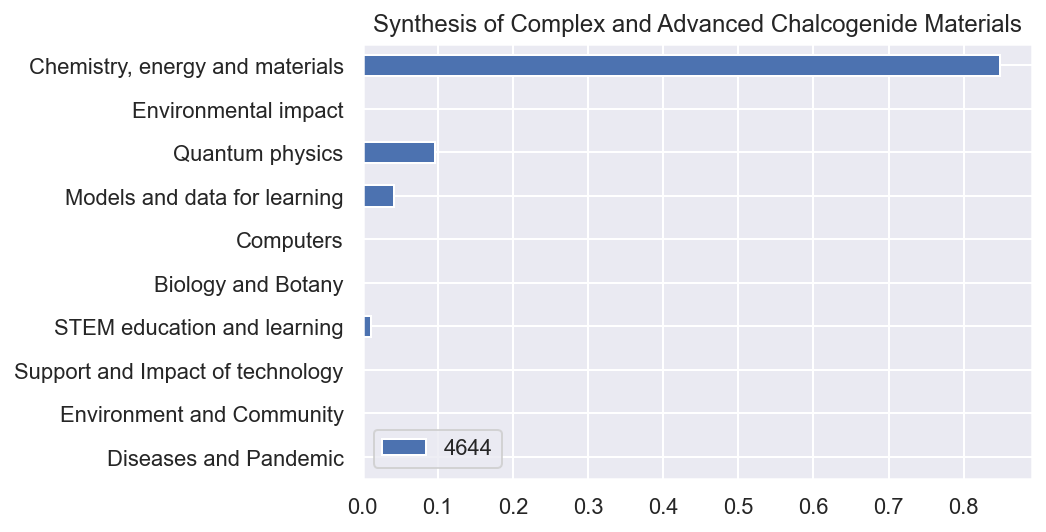

In [73]:
record = model_output[model_output['file'] == 'sample/2003476.xml']
probs = record[record.columns[5:]]
probs.T.plot(kind = 'barh')
_ = plt.title(record['title'].values[0])

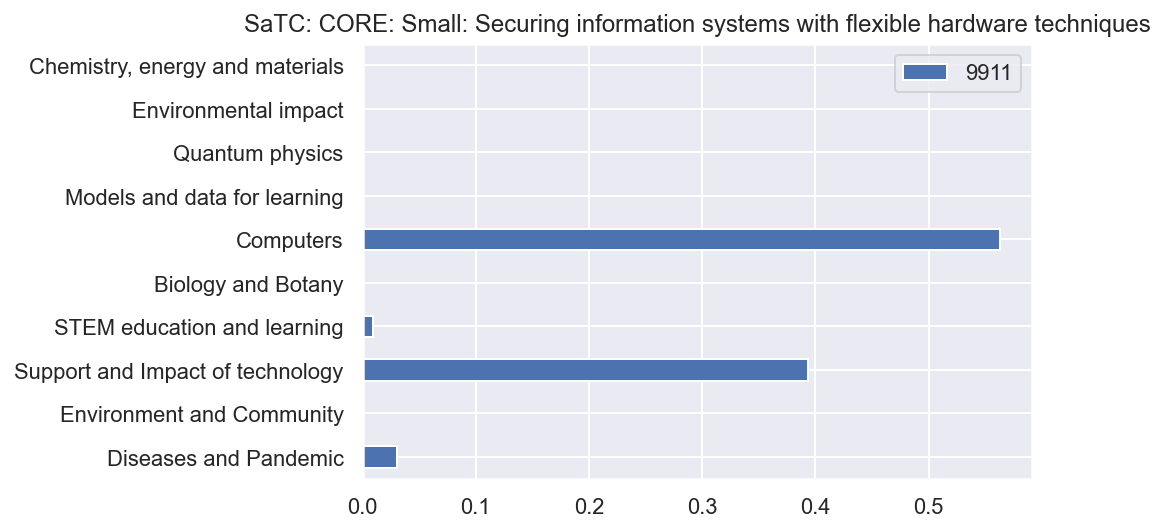

In [74]:
record = model_output[model_output['file'] == 'sample/2026675.xml']
probs = record[record.columns[5:]]
probs.T.plot(kind = 'barh')
_ = plt.title(record['title'].values[0])

## 4. evaluation

We can use a coherence metric to evaluate the quality of each topic, like the one implemented in 
https://tmtoolkit.readthedocs.io/en/latest/api.html#tmtoolkit.topicmod.evaluate.metric_coherence_gensim. However, there seems to be a version conflict between tmtoolkit, gensim and the last version of pandas.

The way to procede would be:
* Calculate the coherence metric for each topic selecting the top_n words. 
* For this top n words we can calculate the coherence metric with the cosine similarity and, if this is a high value, the topic is well done. 
* We can select the number of words we wish to compare, if n is small the coherence of topics will go up but it would be based on less words, so there is a tradeoff between both.

Also, we can improve the results by using a grid search method for the training with different number of topics, iterations and batch sizes and seeing the effect of the hiperparameters on the the coherence metric output.